<a href="https://colab.research.google.com/github/judebebo32/ML_CLG/blob/main/Douglas_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
!pip install scikeras -q
!pip install feature-engine -q
!pip install hyperopt -q
!pip install hpsklearn -q
!pip install tune_sklearn -q
!pip install mlens -q
!pip install shap -q

#!pip install torch
#!pip install skorch

import pandas as pd
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import check_random_state
import tensorflow as tf
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.gridspec as gridspec

from sklearn.ensemble import IsolationForest
from sklearn.inspection import permutation_importance
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from tune_sklearn import TuneSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

# Import basic operations and plotting
import pandas as pd
import numpy as np
import math
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Import filters to remove unnecessary warnings
from warnings import simplefilter
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning

# Import error performance measure, preprocessing etc. from sklearn
from sklearn.model_selection import RepeatedKFold, ParameterGrid
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
# Import Machine Learning Models from sklearn and other libraries

import mlens
from mlens.parallel import Learner, Transformer, Pipeline, Group, Layer, make_group
from mlens.ensemble import BaseEnsemble
from mlens.index import FoldIndex, FullIndex
from mlens.utils import check_instances
from mlens.ensemble.base import check_kwargs

# Import feature importance assessment methods
from sklearn.inspection import permutation_importance
import shap




In [ ]:
def load_data():
    data = pd.read_csv('clean_data.xlsx')
    # drop duplicates
    data = data.drop_duplicates()
    data.reset_index(drop=True, inplace=True)
    data = data.astype('float32')

    # split into input (X) and output (Y) variables
    X = data[['Cel', 'Hem', 'Lig', 'Vm%', 'Ash%', 'FC%', 'C-%',
              'H-%', 'O-%', 'N-%', 'Size', 'HR', 'PT', 'Temp']]

    #X = data[['Lig', 'Ash%', 'O-%', 'H-%', 'N-%', 'Size', 'PT']]
    Y = data[['H/C', 'O/C', 'Oil_yield%', 'Gas_yield%', 'Char_yield%']]

    return X, Y

def clean_data(data:pd.DataFrame)->pd.DataFrame:
  """
  A function that replaces the nan or missing values of each column with the mean value of that column respectively,
  converts the data to the right format
  """
  for col in data.columns:
    if data[col].dtype !='float':
      data[col] = pd.to_numeric(data[col],errors='coerce')
  return data.fillna(data.mean())



def add_features(data:pd.DataFrame):
  df = data.copy()
  df['Cel_Hem_lig']= data.loc[:,'Cel']+data.loc[:,'Hem']+data.loc[:,'Lig']
  df['Cel_Hem_O']= data.loc[:,'Cel']+data.loc[:,'Hem']+data.loc[:,'O-%']
  df['Hem_lig']= data.loc[:,'Hem']+data.loc[:,'Lig']
  df['FC_Vm']= data.loc[:,'FC%']+data.loc[:,'Vm%']
  df['FC_Ash']= data.loc[:,'FC%']+data.loc[:,'Ash%']
  df['FC_Vm_Ash']= data.loc[:,'FC%']+data.loc[:,'Ash%']+data.loc[:,'Vm%']
  df['C_O']= data.loc[:,'C-%']+data.loc[:,'O-%']

  return df


def outlier_threshold(normality, k=1.5):
    # use k =1.5
    q1 = np.quantile(normality, 0.25)
    q3 = np.quantile(normality, 0.75)
    threshold = q1 - k*(q3-q1)
    return threshold


def remove_outlier(X):
    clf = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        n_jobs=-1,
        random_state=5)

    clf.fit(X)
    normality_df = pd.DataFrame(
        clf.decision_function(X), 
        columns=['normality'])
    
    threshold = outlier_threshold(normality_df['normality'].values, k=1.5)

    # Plots the distribution and the threshold
    fig = px.histogram(normality_df, x='normality', width=400, height=400)
    fig.add_vline(x=threshold, line_width=3,
                  line_dash="dash", line_color="red")
    fig.update_layout(width=670, height=400)
    fig.show()

    # remove outliers from both the x and y data
    x_new = X[normality_df['normality'].values >= threshold]
    y_new = Y[normality_df['normality'].values >= threshold]
    print('{} out of {} observations are removed from the dataset'.format(
        (X.shape[0] - x_new.shape[0]), X.shape[0]))

    return x_new, y_new

In [ ]:
#corr = data[['Cel', 'Hem', 'Lig', 'Vm%', 'Ash%', 'FC%', 'C-%', 'H-%', 'O-%', 'N-%','Size','HR', 'PT', 'Temp','H/C','O/C','Oil_yield%','Gas_yield%','Char_yield%']].corr(method = 'spearman')
#fig =plt.figure(figsize=(16,10))
# sns.heatmap(corr, cmap="Blues", annot=True)
# plt.show()

In [ ]:
#Y.describe()

In [ ]:
def pre_scale_data(df_feat:pd.DataFrame,df_tar:pd.DataFrame,sc:str):
  df_features = clean_data(df_feat.copy())
  df_target = clean_data(df_tar.copy())


  if sc=='MS':
    mm_X = MinMaxScaler(feature_range=(0,1))
    mm_Y = MinMaxScaler(feature_range=(0,1))
  if sc == 'SC':
    mm_X = StandardScaler()
    mm_Y = StandardScaler()
  if sc == 'RS':
    mm_X = RobustScaler()
    mm_Y = RobustScaler()

  X = mm_X.fit_transform(df_features)
  Y = mm_Y.fit_transform(df_target)


  return X,Y,mm_X,mm_Y
    
def post_scale_data(mm_X,mm_Y,df_X,df_Y):
  df_post_X = mm_X.inverse_transform(df_X)
  df_post_Y = mm_Y.inverse_transform(df_Y)

  return df_post_X,df_post_Y

In [ ]:
model_list = []
for name in ['SVM', 'RF', 'XGB', 'ANN', 'GBR','ADA','SGD']:
  model_list.append(np.full(5, name))
  
best_cv_df = pd.DataFrame({'model': np.hstack((model_list)), 'RMSLE':None, 'best_hyper_param':None})

In [ ]:
# cost function for multisuperlearner models
def rmse(yreal, yhat):
 return mean_squared_error(yreal, yhat,squared=False)

In [ ]:
# First, your new Learner. ``num_targets`` will be your multi-output dimensionality.

class MultiLearner(Learner):

    def __init__(self, estimator, num_targets, **kwargs):
        super(MultiLearner, self).__init__(estimator, **kwargs)
        self.num_targets = num_targets

    def _get_multiplier(self, X, y):
        return self.num_targets


def make_multi_group(indexer, estimators, preprocessing,
                     learner_kwargs=None, transformer_kwargs=None, name=None):
    preprocessing, estimators = check_instances(estimators, preprocessing)

    if learner_kwargs is None:
        learner_kwargs = {}
    if transformer_kwargs is None:
        transformer_kwargs = {}

    transformers = [Transformer(estimator=Pipeline(tr, return_y=True),
                                name=case_name, **transformer_kwargs)
                    for case_name, tr in preprocessing]

    # We use your new MultiLearner class here
    learners = [MultiLearner(estimator=est, preprocess=case_name,
                        name=learner_name, **learner_kwargs)
                for case_name, learner_name, est in estimators]

    group = Group(indexer=indexer, learners=learners,
                  transformers=transformers, name=name)
    return group


# Change the make_group function in the base ensemble class


class MultiBaseEnsemble(BaseEnsemble):

    def _build_layer(self, estimators, indexer, preprocessing, **kwargs):
        check_kwargs(kwargs, ['backend', 'n_jobs'])
        verbose = kwargs.pop('verbose', max(self._backend.verbose - 1, 0))
        dtype = kwargs.pop('dtype', self._backend.dtype)
        propagate = kwargs.pop('propagate_features', None)
        shuffle = kwargs.pop('shuffle', self.shuffle)
        random_state = kwargs.pop('random_state', self.random_state)
        rs = kwargs.pop('raise_on_exception', self.raise_on_exception)
        if random_state:
            random_state = check_random_state(random_state).randint(0, 10000)

        kwargs['verbose'] = max(verbose - 1, 0)
        kwargs['scorer'] = kwargs.pop('scorer', self.scorer)

        # We use your make_multi_group function from above
        group = make_multi_group(indexer, estimators, preprocessing, kwargs)

        name = "layer-%i" % (len(self._backend.stack) + 1)  # Start count at 1
        lyr = Layer(
            name=name, dtype=dtype, shuffle=shuffle,
            random_state=random_state, verbose=verbose,
            raise_on_exception=rs, propagate_features=propagate)
        lyr.push(group)
        return lyr
    

# Finally, build the MultiSuperLearner (or similar)

class MultiSuperLearner(MultiBaseEnsemble):

    def __init__(
            self, folds=2, shuffle=False, random_state=None, scorer=None,
            raise_on_exception=True, array_check=None, verbose=False, n_jobs=-1,
            backend='threading', model_selection=False, sample_size=20, layers=None):
        super(MultiSuperLearner, self).__init__(
            shuffle=shuffle, random_state=random_state, scorer=scorer,
            raise_on_exception=raise_on_exception, verbose=verbose,
            n_jobs=n_jobs, layers=layers, backend=backend,
            array_check=array_check, model_selection=model_selection,
            sample_size=sample_size)

        self.__initialized__ = 0  # Unlock parameter setting
        self.folds = folds
        self.__initialized__ = 1  # Protect against param resets

    def add_meta(self, estimator, **kwargs):
        return self.add(estimators=estimator, meta=True, **kwargs)

    def add(self, estimators, num_targets=1, preprocessing=None,
            proba=False, meta=False, propagate_features=None, **kwargs):
        c = kwargs.pop('folds', self.folds)

        if meta:
            idx = FullIndex()
        else:
            idx = FoldIndex(c, raise_on_exception=self.raise_on_exception)

        return super(MultiSuperLearner, self).add(
            estimators=estimators, num_targets=num_targets, indexer=idx, preprocessing=preprocessing,
            proba=proba, propagate_features=propagate_features, **kwargs)

In [ ]:
def relative_error_percent(prediction, y):
  """
  A function to calculate the relative error percent between the predicted value and actual values
  """
  rel_error = 2 * np.absolute(y - prediction) / (np.absolute(y) + np.absolute(prediction))
    
  return rel_error*100
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------#

def get_scores(X,Y,opt=False):
  complete_score = pd.DataFrame()
  models = ['SVM', 'RF', 'XGB', 'ANN', 'GBR','ADA','SGD']
  for modelname in models :
    if opt == False:
      performance =build_models(X,Y,test_fraction =0.15, modelname = modelname, random_state = 42, CV_folds = 5, optimisation = opt, display = False) 
      complete_score = pd.concat([complete_score,performance],axis=0)
    if opt == True:
      if modelname != 'SVM':
        performance =build_models(X,Y,test_fraction =0.14, modelname = modelname, random_state = 42, CV_folds = 5, optimisation = opt, display = False) 
        complete_score = pd.concat([complete_score,performance],axis=0)

  complete_score.dropna(axis=1,inplace=True)
  if opt == True:
    complete_score.index = ['RF', 'XGB', 'ANN', 'GBR','ADA','SGD']
  else:
    complete_score.index = models


  return complete_score
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

def plot_correlation(data:np,cols=['Cel', 'Hem', 'Lig', 'Vm%', 'Ash%', 'FC%', 'C-%', 'H-%', 'O-%', 'N-%','Size','HR', 'PT', 'Temp']):
  """
  Function that shows the correlation and clustering between the features:
  
  """
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
  corr = spearmanr(X).correlation

  # Ensure the correlation matrix is symmetric
  corr = (corr + corr.T) / 2
  np.fill_diagonal(corr, 1)
  # We convert the correlation matrix to a distance matrix before performing
  # hierarchical clustering using Ward's linkage.
  distance_matrix = 1 - np.abs(corr)
  dist_linkage = hierarchy.ward(squareform(distance_matrix))
  dendro = hierarchy.dendrogram(
      dist_linkage, labels=cols, ax=ax1, leaf_rotation=90
  )
  dendro_idx = np.arange(0, len(dendro["ivl"]))

  ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
  ax2.set_xticks(dendro_idx)
  ax2.set_yticks(dendro_idx)
  ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
  ax2.set_yticklabels(dendro["ivl"])
  fig.tight_layout()
  plt.show()

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

def plot_train_set(y_train_df:pd.DataFrame,y_train_pred_df:pd.DataFrame,y_test_df:pd.DataFrame,y_test_pred_df:pd.DataFrame):
  """ A function that plots the comparison of the predictions of the various target variables for a ML models 
      fitted from the training set and testing set.
      params:
      y_train_df: A dataframe containing the original training dataset
      y_train_pred_df: A dataframe containing the predictions for the training dataset,
      y_test_df:  A dataframe containing the original testing dataset
      y_test_pred_df: A dataframe containing the predictions for the testing dataset 
  """

  plt.rcParams.update({'font.size': 10})
  fig=plt.figure(figsize=(15,7))
  spec = mpl.gridspec.GridSpec(ncols=6, nrows=2) # 6 columns evenly divides both 2 & 3
  ax1 = fig.add_subplot(spec[0,0:2]) # row 0 with axes spanning 2 cols on evens
  ax2 = fig.add_subplot(spec[0,2:4])
  ax3 = fig.add_subplot(spec[0,4:])
  ax4 = fig.add_subplot(spec[1,1:3]) # row 0 with axes spanning 2 cols on odds
  ax5 = fig.add_subplot(spec[1,3:5])
  all_axis = [ax1,ax2,ax3,ax4,ax5]
  for val in zip(y_train_df.columns,all_axis):
    col,graph = list(val) 
    graph.scatter(y_train_df[col], y_train_pred_df[col])
    graph.scatter(x=y_test_df[col], y=y_test_pred_df[col],color='red',marker='o')
    # add straight line
    line = np.linspace(np.min(y_train_df.to_numpy()),np.max(y_train_df.to_numpy()))
    graph.plot(line, line, linewidth=1.5,color='orange', zorder=4)
    graph.set_ylim(ymin=0,ymax=1.01)
    graph.set_xlim(xmin=0,xmax=1.01)
    # Add error regions
    graph.fill_between(line, line - 0.12, line + 0.12, color='grey',linestyle='dashed',alpha = 0.05) # 12% error
    #ax1.fill_between(line, line - 0.2, line + 0.2,color ='blue',linestyle='dashed', alpha = 0.05) # 20% error
    # set labels
    graph.set(xlabel=f'Measured {col}', ylabel=f'Predicted {col}')
    graph.legend(loc='upper left', labels=['X - Y','Training Set', 'Testing Set','12% deviation line'])
    plt.tight_layout()
  plt.show()
#-------------------------------------------------------------------------------------------------------------------------------------------------------------#

def plot_feat_importance(model,y_train_df,x_cols):
  
  cols = x_cols
  y_cols = y_train_df.columns
  fig=plt.figure(figsize=(15,8))
  spec = mpl.gridspec.GridSpec(ncols=6, nrows=2) # 6 columns evenly divides both 2 & 3
  ax1 = fig.add_subplot(spec[0,0:2]) # row 0 with axes spanning 2 cols on evens
  ax2 = fig.add_subplot(spec[0,2:4])
  ax3 = fig.add_subplot(spec[0,4:])
  ax4 = fig.add_subplot(spec[1,1:3]) # row 0 with axes spanning 2 cols on odds
  ax5 = fig.add_subplot(spec[1,3:5])
  all_axis = [ax1,ax2,ax3,ax4,ax5]
  ### Get the feature importance for each target
  for val in zip(range(len(model.estimators_)),all_axis):
    i,graph = list(val)
    feature_importance = model.estimators_[i].feature_importances_
    sorted_idx = np.argsort(feature_importance)
    graph.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    graph.set_yticks(range(len(sorted_idx)))
    graph.set_yticklabels(np.array(cols)[sorted_idx])
    graph.set(xlabel=f'Feature Importance for {y_cols[i]}', ylabel='Feature names')
  plt.tight_layout()
  plt.show()
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
def plot_perm_feat_importance(model,y_train_df,x_cols,X_train,y_train):
  
  cols = x_cols
  y_cols = y_train_df.columns
  result = permutation_importance(model, X_train, y_train, n_repeats=10,n_jobs=2,random_state=42)
  perm_sorted_idx = result.importances_mean.argsort()
  tree_importance_sorted_idx = np.argsort(model.estimators_[0].feature_importances_)
  tree_indices = np.arange(0, len(model.estimators_[0].feature_importances_)) + 0.5
  
  fig=plt.figure(figsize=(15,8))
  spec = mpl.gridspec.GridSpec(ncols=6, nrows=2) # 6 columns evenly divides both 2 & 3
  ax1 = fig.add_subplot(spec[0,0:2]) # row 0 with axes spanning 2 cols on evens
  ax2 = fig.add_subplot(spec[0,2:4])
  ax3 = fig.add_subplot(spec[0,4:])
  ax4 = fig.add_subplot(spec[1,1:3]) # row 0 with axes spanning 2 cols on odds
  ax5 = fig.add_subplot(spec[1,3:5])
  all_axis = [ax1,ax2,ax3,ax4,ax5]
  ### Get the feature importance for each target
  for val in zip(range(len(model.estimators_)),all_axis):
    i,graph = list(val)
    graph.boxplot(
      result.importances[perm_sorted_idx].T,
      vert=False,
      labels=np.array(cols)[perm_sorted_idx],
  )
    graph.axvline(x=0, color="k", linestyle="--")
    graph.set(xlabel=f'Permutation Feature Importance for {y_cols[i]}', ylabel='Feature names')
  fig.tight_layout()
  plt.show()

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

def plot_errors(y_train_df,y_train_pred_df,y_test_df ,y_test_pred_df):
  err_train = relative_error_percent(y_train_pred_df,y_train_df)
  err_test = relative_error_percent(y_test_pred_df,y_test_df)
  cols = y_train_df.columns  # get target columns
  # Create Subplots
  fig = make_subplots(rows=1, cols=2)
  #  Plots errors for each target in train data

  for xd in cols:
    fig.add_trace(go.Box(
        y=err_train[xd],
        name=xd,
        boxpoints='all',
        marker_size=2,
        ), row=1, col=1
    )

    #  Plots errors for each target in test data

  for xd in cols:
    fig.add_trace(go.Box(
        y=err_test[xd],
        name=xd,
        boxpoints='all',
        marker_size=2,
        ), row=1, col=2
    )
  # Update the plots layout
  fig.update_xaxes(showline = True, linecolor = 'black', linewidth = 1, row = 1, col = 1, mirror = True)
  fig.update_yaxes(showline = True, linecolor = 'black', linewidth = 1, row = 1, col = 1, mirror = True,title_text = "Relative error (%)",)
  fig.update_xaxes(showline = True, linecolor = 'black', linewidth = 1, row = 1, col = 2, mirror = True)
  fig.update_yaxes(showline = True, linecolor = 'black', linewidth = 1, row = 1, col = 2, mirror = True,title_text = "Relative error (%)",)

  fig.update_layout(plot_bgcolor="#FFFFFF",width=1000,height=450,showlegend=False)
  fig.show()
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
def plot_shap_importances(model_norm,x_train, x_test, y_train, y_test,x_cols,y_cols=['H/C','O/C','Oil_yield%','Gas_yield%','Char_yield%']):
  """
    Plot the SHAP importances for a given model and dataset.

    Args:
    model_norm (sklearn estimator): A fitted sklearn estimator for multi-output regression.
    x_train (numpy array or pandas DataFrame): Training set features.
    x_test (numpy array or pandas DataFrame): Test set features.
    y_train (numpy array or pandas DataFrame): Training set targets.
    y_test (numpy array or pandas DataFrame): Test set targets.
    x_cols (list of strings): List of feature names.
    y_cols (list of strings, optional): List of target names. Defaults to ['H/C', 'O/C', 'Oil_yield%', 'Gas_yield%', 'Char_yield%'].

    Returns:
    None
  """
  #Initialize the model
  model = MultiOutputRegressor(model_norm)
  # Fit the model
  model.fit(x_train, y_train)
  # Fits the explainer
  explainer = shap.KernelExplainer(model = model.predict, data = x_test, link = "identity")
  # Get the shap values
  shap_values = explainer.shap_values(X = x_test)
  ##plot the summary plot
  shap.summary_plot(shap_values = shap_values,
                  features = x_test,
                  feature_names=x_cols,
                  class_names = y_cols,
                  plot_size= (10,7),
                  
  )
   
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
def plot_partial_dependencies(model_norm,x_train,y_train,x_cols):
    """
    Plot partial dependence plots for each output label and each input feature.

    Parameters:
    -----------
    model_norm: object
        A normalized regression model
    x_train: array-like
        Training data features
    y_train: array-like
        Training data labels
    x_cols: list
        List of feature names
    cols: list, optional (default=[i for i in range(14)])
        List of feature indices to plot
        
    Returns:
    --------
    None
    """
    
    # Define output label names
    y_cols = ['H/C','O/C','Oil_yield%','Gas_yield%','Char_yield%']  
    x_train_df = pd.DataFrame(x_train,columns= x_cols)

    # Iterate through each output label and plot partial dependence plots for each input feature
    for i in range(len(y_cols)):
        # Fit model to training data
        model_norm.fit(x_train_df, y_train[:,i])

        # Create figure and gridspec for subplots
        fig = plt.figure(figsize=(18, 20))
        gs = gridspec.GridSpec(len(x_cols),3, figure=fig)

        # Create subplots
        axs = [fig.add_subplot(gs[i]) for i in range(len(x_cols))]
    
        # Plot partial dependence plots for each input feature
        PartialDependenceDisplay.from_estimator(model_norm, x_train_df, x_train_df.columns, ax=axs)
        
        # Adjust subplot spacing
        fig.subplots_adjust(wspace=0.3,hspace=0.3)
    
    # Adjust figure spacing
    fig.tight_layout();
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------#
def evaluate_model(modelname,model,x_train,y_train,x_test, y_test,CV_folds,optimisation,param_grid):
  """ 
  A function that evaluates the performance of each model

  params:
  ------
  modelname: A str ['RF','ANN','GBR','XGBoost','SVM','AdaBoost']
  model: Required model 
  x_train: A dataframe containing the training features/ Independent variable
  y_train: A dataframe comtaining the training labels / Dependent variables
  x_test: A dataframe containing the testing features/ Independent variable
  y_test: A dataframe comtaining the testing labels / Dependent variables

  return:
  -------
  Perf_sum: A dataframe containing the performance summary of the given model
  y_test_pred: A dataframe containing the predicted labels

  """
  perf_sum = pd.DataFrame(columns= ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MSE_train', 'MSE_test','R2_CV', 'RMSE_CV'],index=[0])  
  
  if modelname in ['RF','ANN']:
    if optimisation:
      simplefilter('ignore', category=FutureWarning) # turn depreciation warnings off
      # Specify a hyper parameter tuning algorithm
      tune_search = TuneSearchCV(
          model,
          param_grid,
          search_optimization='hyperopt',
          n_trials=10,
          n_jobs=-1,
          scoring={'RMSLE':'neg_mean_squared_error'},
          cv=CV_folds,
          refit='RMSLE',
          verbose=1,
          random_state=5
          )
      tune_search.fit(x_train, y_train)
      ## Save the optimal hyper parmater values
      best_cv_df.loc[best_cv_df['model']==modelname, 'best_hyper_param'] = str(tune_search.best_params_)
      ## Save the CV results
      cv_df = pd.DataFrame(tune_search.cv_results_)
      cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
      best_cv_df.loc[best_cv_df['model']==modelname, 'RMSLE'] = cv_values[:5]

      # Visualize the tuning results with parallel coordinate plot
      tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)    
      best_parameters = tune_search.best_params_
      #model = RandSearch_model.best_estimator_ # select best estimator as model for rest of code
      model = tune_search.best_estimator_
      simplefilter('ignore', category=FutureWarning) # turn depreciation warnings off 
      print(f'Best parameters for the model are {best_parameters}') 
      
    else:
      # fit model
      model.fit(x_train, y_train)
      best_parameters = 'default'
      
  if modelname in ['GBR','XGB','SVM','ADA','SGD']:
    model = MultiOutputRegressor(model)
    if optimisation:
      simplefilter('ignore', category=FutureWarning) # turn depreciation warnings off
      # Specify a hyper parameter tuning algorithm
      tune_search = TuneSearchCV(
          model,
          param_grid,
          search_optimization='hyperopt',
          n_trials=10,
          n_jobs=-1,
          scoring={'RMSLE':'neg_mean_squared_error'},
          cv=CV_folds,
          refit='RMSLE',
          verbose=1,
          random_state=5
          )
      
      tune_search.fit(x_train, y_train)
      ## Save the optimal hyper parmater values
      best_cv_df.loc[best_cv_df['model']==modelname, 'best_hyper_param'] = str(tune_search.best_params_)
      ## Save the CV results
      cv_df = pd.DataFrame(tune_search.cv_results_)
      cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
      best_cv_df.loc[best_cv_df['model']==modelname, 'RMSLE'] = cv_values[:5]

      # Visualize the tuning results with parallel coordinate plot
      tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
      best_parameters = tune_search.best_params_
      model = tune_search.best_estimator_
      simplefilter('ignore', category=FutureWarning) # turn depreciation warnings off 
      print(f'Best parameters for the model are {best_parameters}') 
    else:
      # fit model
      simplefilter('ignore', category=FutureWarning) # turn depreciation warnings off 
      simplefilter('ignore', category=ConvergenceWarning) # turn convergence warnings off
      model = model.fit(x_train, y_train)
      if modelname =='GBR' and x_train.shape[1] == 7:
        # Download the trained model
        filename = 'trained_gbrmodel.sav'
        pickle.dump(model, open(filename, 'wb'))
      best_parameters = 'default' 

  # make predictions
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)

  # Evaluate performance - other performance measures can be shown with sorted(sklearn.metrics.SCORERS.keys())
  R2_train = np.round(model.score(x_train, y_train),2)
  R2_test = np.round(model.score(x_test, y_test),2)
  # RMSE
  RMSE_train = mean_squared_error(y_train, y_train_pred, squared=False)
  RMSE_test = mean_squared_error(y_test, y_test_pred, squared=False)
  # MSE
  MSE_train = mean_squared_error(y_train, y_train_pred)
  MSE_test = mean_squared_error(y_test, y_test_pred)
  #MAE
  MAE_train = mean_absolute_error(y_train, y_train_pred)
  MAE_test = mean_absolute_error(y_test, y_test_pred)

  # Evaluate cross validated performance on entire dataset. Combine datasets again before calculating cross validation scores
  
  x_complete = pd.concat([pd.DataFrame(x_train), pd.DataFrame(x_test)],axis=0)
  y_complete = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)],axis=0)

  # Calculate cross validated scores 
  CV_R2_scores = cross_val_score(model, x_complete, y_complete, cv=CV_folds, scoring='r2')
  R2_CV = np.mean(CV_R2_scores)
  CV_RMSE_scores = -cross_val_score(model, x_complete, y_complete, cv=CV_folds, scoring='neg_root_mean_squared_error')
  RMSE_CV = np.mean(CV_RMSE_scores)

  # Store performance indicators and other information in dataframe:Performance measure (R2, RMSE, etc)
  perf_sum['R2_train'] = R2_train
  perf_sum['R2_test'] = R2_test       
  perf_sum['RMSE_train'] = RMSE_train    
  perf_sum['RMSE_test'] = RMSE_test    
  perf_sum['R2_CV'] = R2_CV    
  perf_sum['RMSE_CV'] = RMSE_CV
  perf_sum['MSE_train'] = MSE_train
  perf_sum['MSE_test'] = MSE_test
  perf_sum['MAE_train'] = MAE_train
  perf_sum['MAE_test'] = MAE_test
 
  perf_sum[modelname] = modelname

  return perf_sum,model,y_test_pred,y_train_pred

In [ ]:
# Create one function which can fit any of the considered models with an range of possible pretreatment options
def build_models(X, Y,test_fraction, modelname = 'RF', random_state = 42, CV_folds = 5, optimisation = False, display = True,x_cols=['Cel', 'Hem', 'Lig', 'Vm%', 'Ash%', 'FC%', 'C-%', 'H-%', 'O-%', 'N-%','Size','HR', 'PT', 'Temp'],graph=False ):
    """
    Function to build models to be trained,tested and optimized.
    A number of different ML algorithms are supported and may be defined by the variable 'modelname'.
    
    Inputs:_cols
    X - features/independent data for model training and testing
    Y - labels(dependent data for model training and testing(multiple target columns possible)
    predictor_pretreatment - specifies the predictor variable pretreatment option
    target_pretreatment - specifies the target variable pretreatment option
    modelname - defines model type (default: 'RF')
    random_state - defines random seed (default: 42)
    CV_folds - define number of cross validation folds (default: 5)
    optimisation - specifies whether hyperparameter tuning is desired or default values are to be used (default: False)
    iterations_RandSearch - specifies the number of iterations for randomised grid search. Higher values cover more combinations but take longer to compute. Should
        be set to a higher value if number of combinations in optimisation grid is high (default: 100)
    display = If True graphs and description of model training are shown. If False these won't be shown (default: True)
    Output:
    performance_summary - pandas dataframe containing trained models, performance measures, and more
    """    
    # Split data into train and test sets:                
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_fraction, random_state= random_state) 
    # --------------------------------------------------------------------------------------------------------------
    param_grid = {}
    # set maximum number of iterations to be used if the optimization is set to True
    if optimisation == True:
      print ('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # \n') # to optimisation information from rest of model


    if display == True:
            print(modelname, 'model selected!\n') # show which model has been selected
            print ('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # \n')
        
    # Select which ML model is to be used and define grid/randomised search parameter grids for hyperparameter optimisation:
    if modelname == 'RF': # Use sklearn's random forest regressor  
        model_norm = RandomForestRegressor(random_state= random_state) 
        
        # Define grid/randomised search parameters
        max_depth = max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
        max_depth.append(None)
        
        param_grid = {
        'n_estimators': [10, 50, 100, 200, 500, 1000, 2000],
        'max_features': [1.0, 'sqrt'],
        'max_depth': max_depth,
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        }

        result,model,y_pred_data,y_train_pred = evaluate_model(modelname,model_norm,x_train,y_train,x_test, y_test,CV_folds,optimisation,param_grid)
       
    elif modelname == 'GBR': # Use sklearn's gradient boosting regressor 
        model_norm = GradientBoostingRegressor(random_state= random_state)
        # Define grid/randomised search parameters
        param_grid= {
        'estimator__loss': ['squared_error', 'absolute_error', 'huber'],
        'estimator__learning_rate': [0.02, 0.05, 0.10, 0.15, 0.20, 0.50],
        'estimator__n_estimators': [10, 50, 100, 200, 500, 1000, 2000],
        'estimator__subsample': [0.6, 0.8, 1.0],
        'estimator__min_samples_split': [2, 5, 10],
        'estimator__min_samples_leaf': [1, 2, 4],
        'estimator__max_depth': [2, 3, 5, 10],
        'estimator__max_features': [1.0, 'sqrt', 0.3],
        }

        result,model,y_pred_data,y_train_pred = evaluate_model(modelname,model_norm, x_train,y_train,x_test, y_test,CV_folds,optimisation,param_grid)
      
    elif modelname == 'XGB': # Use xgboost's extreme gradient boosting regressor 
        model_norm = XGBRegressor(verbosity=0,random_state=random_state)        
        simplefilter('ignore', category=FutureWarning) # turn depreciation warnings off 
        param_grid = {
        'estimator__n_estimators': [10, 50, 100, 200, 500, 1000, 2000],    
        'estimator__max_depth': [2, 5, 7, 10,15,20,25],
        'estimator__learning_rate': [0.01, 0.1, 0.2], 
        'estimator__eta': [0.01, 0.1, 0.3],
        'estimator__min_child_weight': [5, 10, 15],
        'estimator__gamma': list(np.geomspace(1e-2, 1, 3)),
        'estimator__subsample': [0.5, 0.7, 1],
        'estimator__colsample_bytree': [0.5, 0.7, 1],
        }
        
        result,model,y_pred_data,y_train_pred = evaluate_model(modelname,model_norm, x_train,y_train,x_test, y_test,CV_folds,optimisation,param_grid)
        simplefilter('ignore', category=FutureWarning) # turn depreciation warnings off 

    elif modelname == 'ADA': # Use sklearn's AdaBoost regressor
        model_norm = AdaBoostRegressor(random_state= random_state)
                
        # Define grid/randomised search parameters
        base_estimator_depths = list() # define depth of decision tree stumps and base model
        for i in range(1,10,2):
            base_estimator_depths.insert(i, DecisionTreeRegressor(max_depth=i))
        
        param_grid = {
        'estimator__base_estimator': base_estimator_depths, 
        'estimator__n_estimators': [10, 50, 100, 200, 500, 1000, 2000],
        'estimator__learning_rate': [0.2, 0.5, 1, 1.5, 2, 5],
        'estimator__loss': ['linear', 'square', 'exponential']
        }

        result,model,y_pred_data,y_train_pred = evaluate_model(modelname,model_norm, x_train,y_train,x_test, y_test,CV_folds,optimisation,param_grid)
        
    elif modelname == 'SVM': # Use sklearn's support vector machine 
        model_norm =  make_pipeline(MinMaxScaler(), SVR())

        param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','sigmoid','poly','linear']
              }
        
        # if optimisation == True:
        #     print('Note: Optimisation currently not supported for SVM - change to "False" \n')
      
        result,model,y_pred_data,y_train_pred = evaluate_model(modelname,model_norm, x_train,y_train,x_test, y_test,CV_folds,optimisation,param_grid) 
  
    elif modelname == 'ANN': # Use sklearn's multi-layer perceptron
        model_norm = make_pipeline(MinMaxScaler(),MLPRegressor(solver = 'lbfgs', random_state = random_state, early_stopping = True, max_iter = 1000))     
       # model = MLPRegressor(solver = 'lbfgs', random_state = random_state, early_stopping = True, max_iter = 1000)
        
        param_grid = {
        'mlpregressor__hidden_layer_sizes': [int(x) for x in np.linspace(3, 15, num = 7)],  
        'mlpregressor__activation': ['logistic', 'tanh', 'relu'],
        'mlpregressor__solver': ['lbfgs', 'adam'], 
        'mlpregressor__early_stopping': [True, False],
        'mlpregressor__max_iter': [2000] # 200, 500, 1000,
        }
        result,model,y_pred_data,y_train_pred = evaluate_model(modelname,model_norm, x_train,y_train,x_test, y_test,CV_folds,optimisation,param_grid)     
        
        simplefilter('ignore', category=ConvergenceWarning) # turn convergence warnings off

    elif modelname == 'SGD':
      model_norm = SGDRegressor()
      param_grid = {
    'estimator__alpha': list(np.geomspace(1e-7, 1e-3, 3)),
    'estimator__epsilon': list(np.geomspace(1e-5, 1e-1, 3)),
    'estimator__loss': ['huber', 'epsilon_insensitive'],
    'estimator__tol': [1e-5, 1e-4, 1e-3],
    'estimator__max_iter': [1000],
      } 

      result,model,y_pred_data,y_train_pred = evaluate_model(modelname,model_norm, x_train,y_train,x_test, y_test,CV_folds,optimisation,param_grid) 

    else:
        return ('Error: Model name not defined!')
  # ----------------------------------
  # Return outputs as a dataframe:
    
    y_test_pred_df = pd.DataFrame(y_pred_data,columns=['H/C','O/C','Oil_yield%','Gas_yield%','Char_yield%'])
    y_test_df = pd.DataFrame(y_test,columns=['H/C','O/C','Oil_yield%','Gas_yield%','Char_yield%'])
    y_train_pred_df = pd.DataFrame(y_train_pred,columns=['H/C','O/C','Oil_yield%','Gas_yield%','Char_yield%'])
    y_train_df = pd.DataFrame(y_train,columns=['H/C','O/C','Oil_yield%','Gas_yield%','Char_yield%'])

    if graph:
      plot_train_set(y_train_df,y_train_pred_df,y_test_df ,y_test_pred_df)
      print('==========================================================================================================================================================')
      print('==========================================================================================================================================================')
      plot_feat_importance(model,y_train_df,x_cols)
      print('==========================================================================================================================================================')
      print('==========================================================================================================================================================')
      plot_errors(y_train_df,y_train_pred_df,y_test_df ,y_test_pred_df)
      print('==========================================================================================================================================================')
      print('==========================================================================================================================================================')
      plot_perm_feat_importance(model,y_train_df,x_cols,x_train,y_train)
      print('==========================================================================================================================================================')
      print('==========================================================================================================================================================')
      if modelname == 'GBR':
        plot_shap_importances(model_norm,x_train, x_test, y_train, y_test,x_cols)
      print('===========================================================================================================================================================')
      print('==========================================================================================================================================================')
      plot_partial_dependencies(model_norm,x_train,y_train,x_cols)


    return result
        

In [ ]:
# Load data
X, Y = load_data()
# scale the data
X,Y,mm_X,mm_Y = pre_scale_data(X,Y,'MS')
# Remove outliers from data
x_new, y_new = remove_outlier(X)

17 out of 262 observations are removed from the dataset


GBR model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



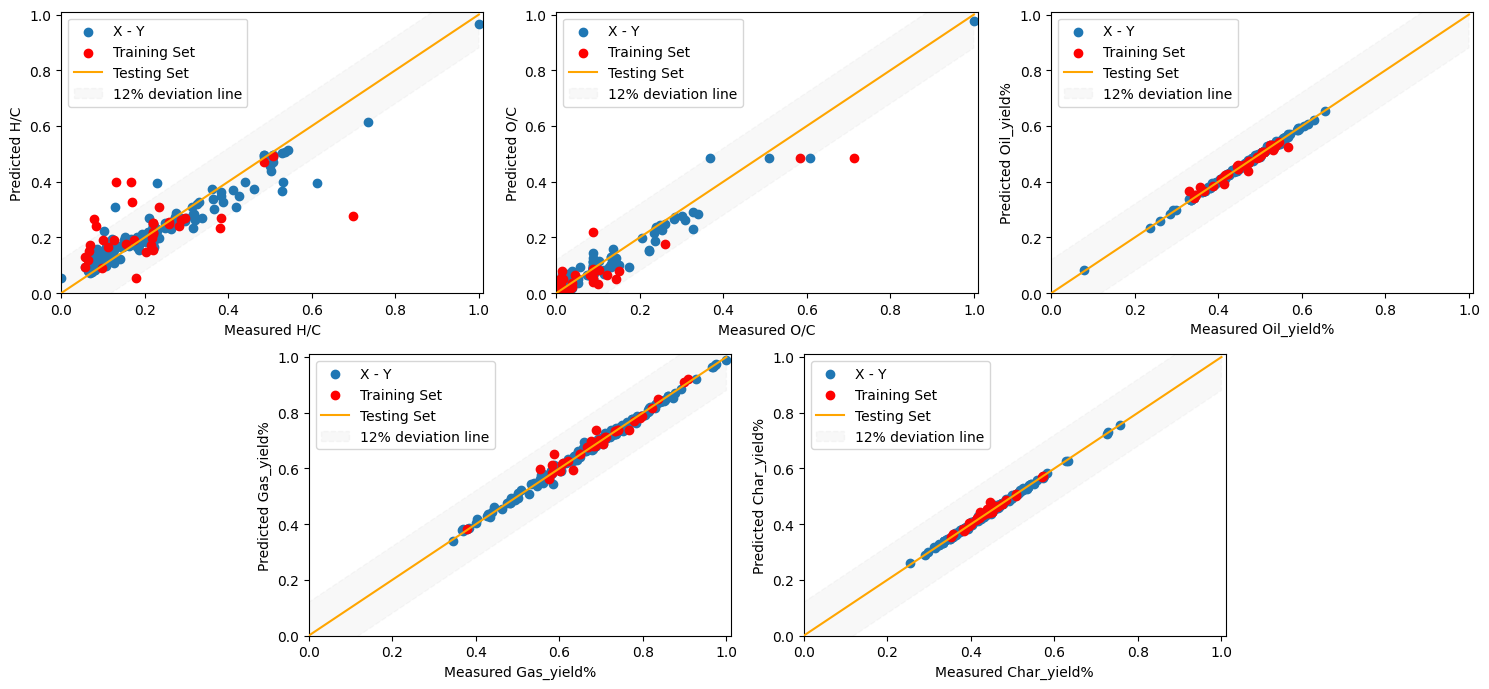

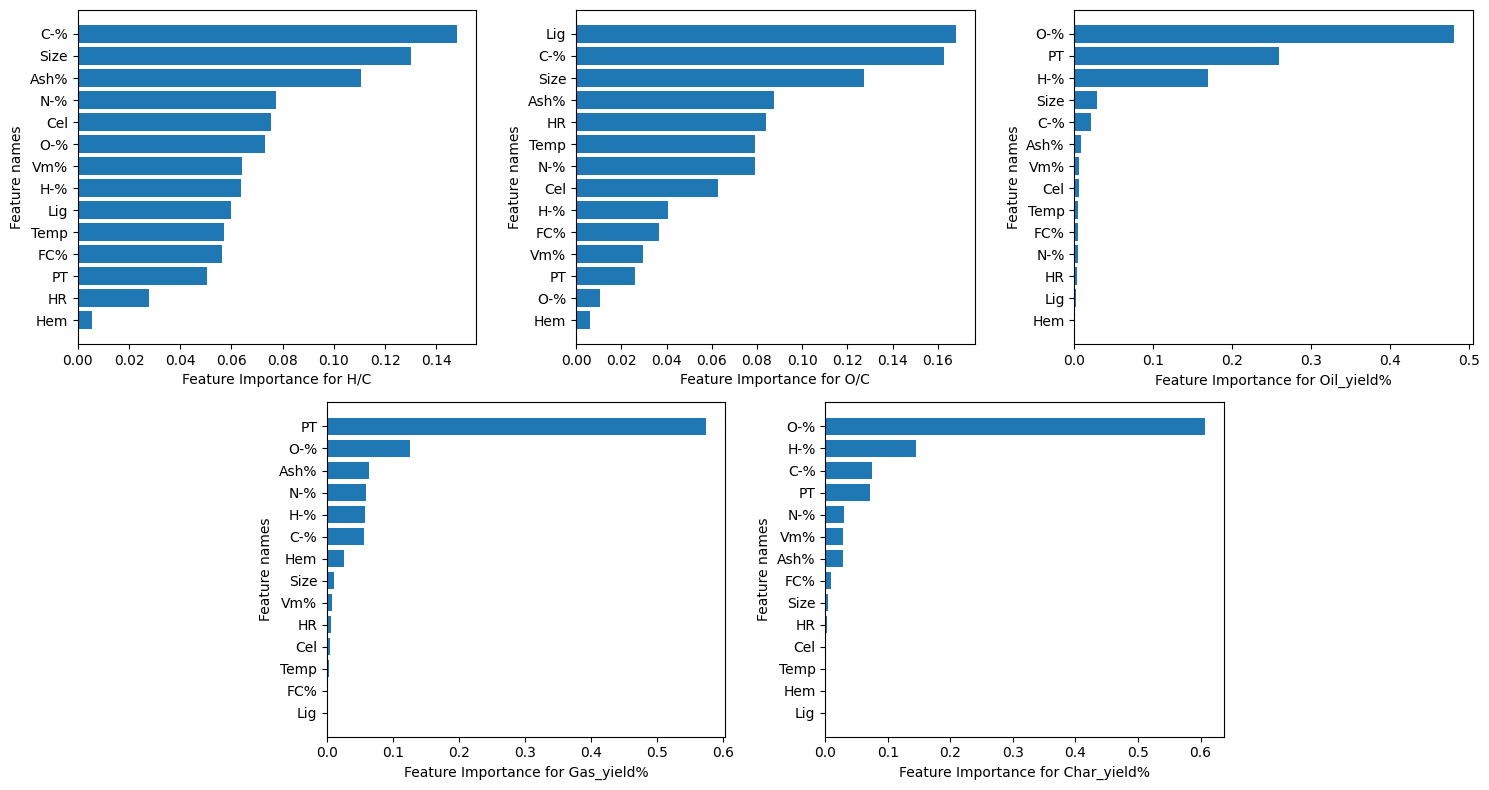

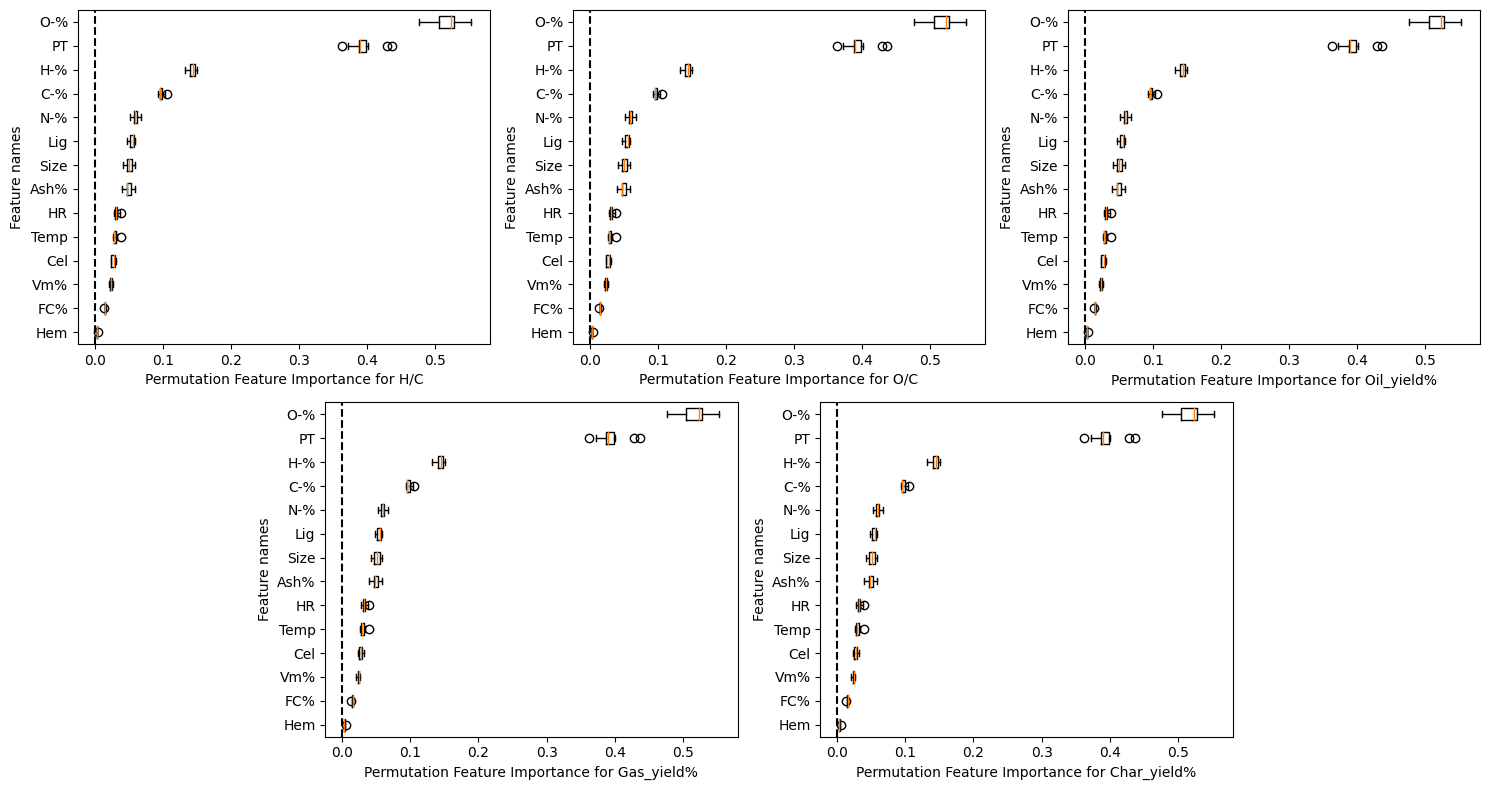

  0%|          | 0/37 [00:00<?, ?it/s]

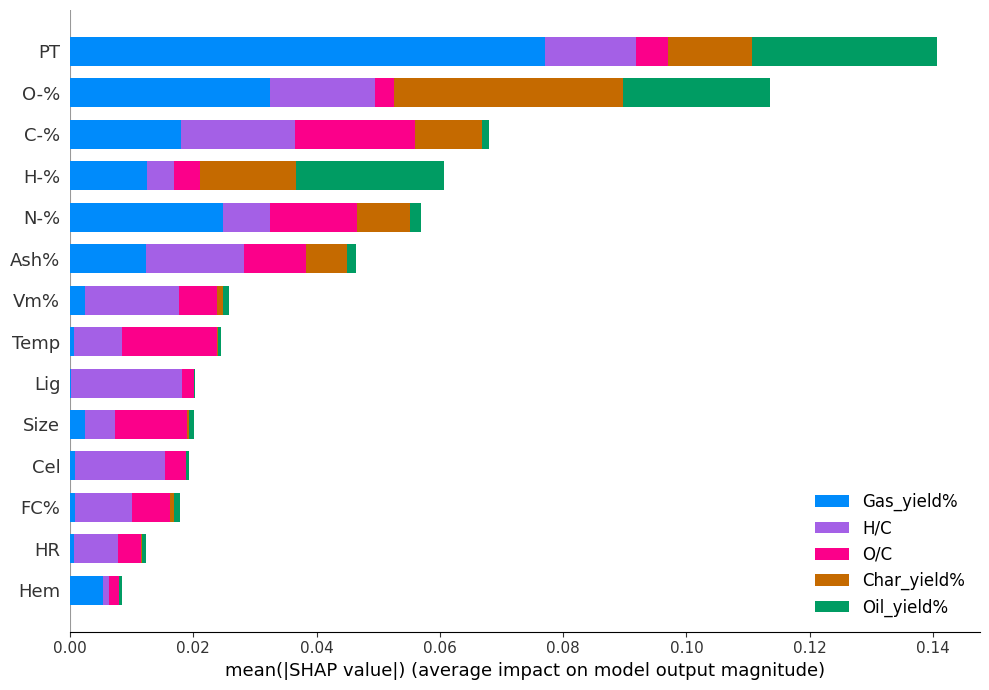

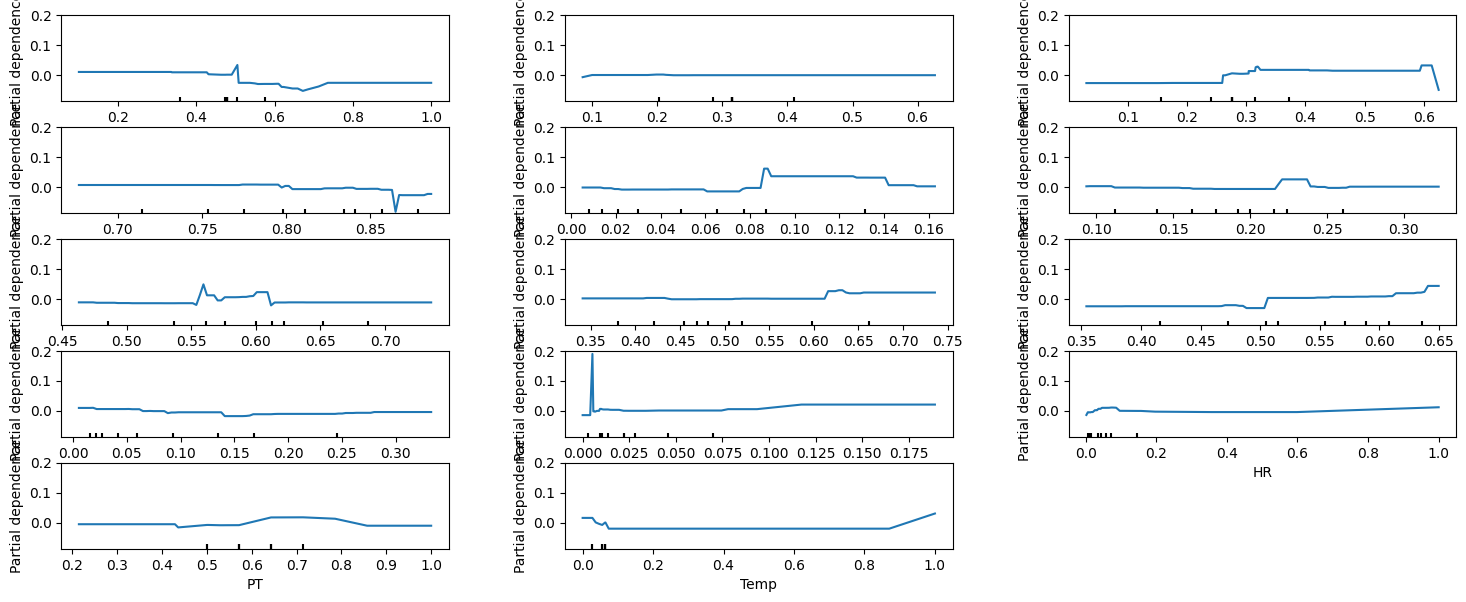

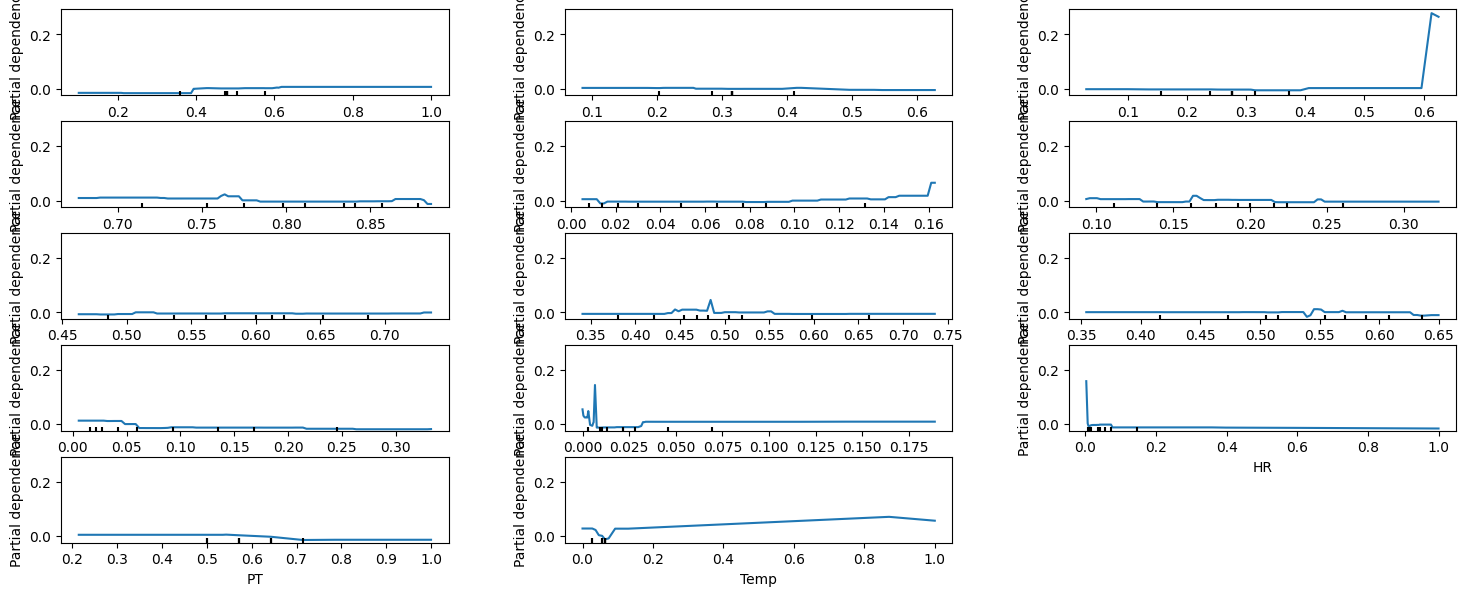

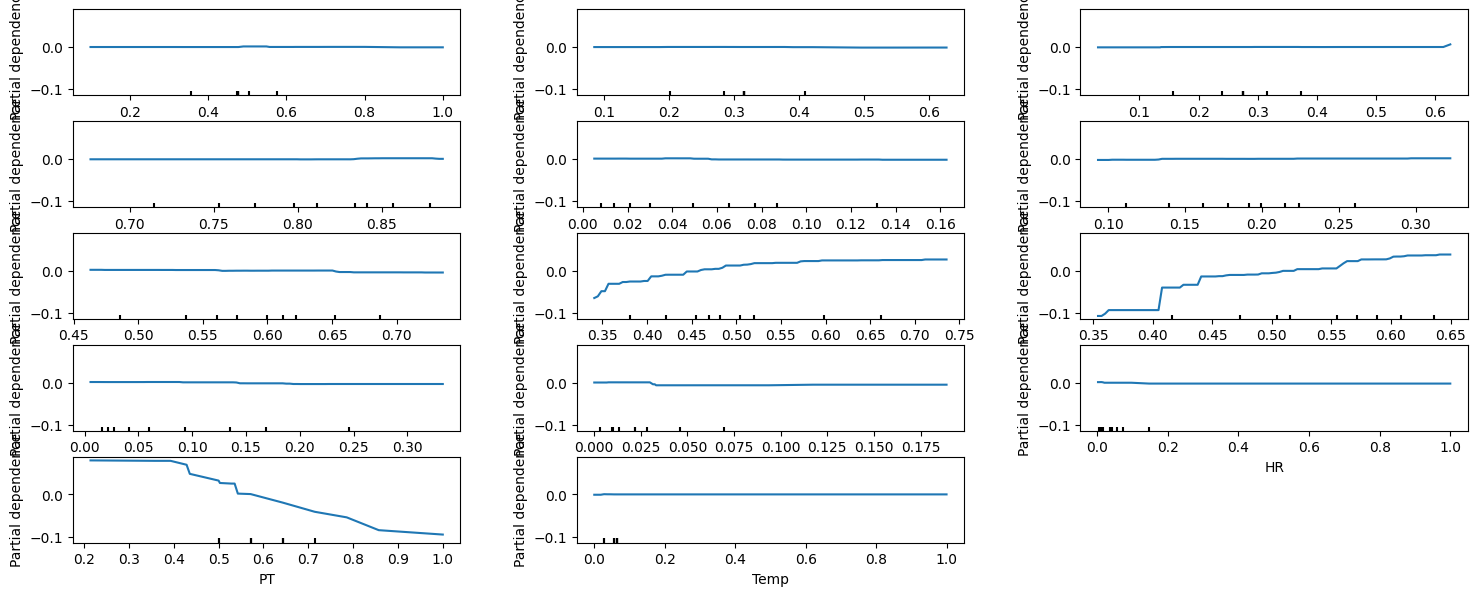

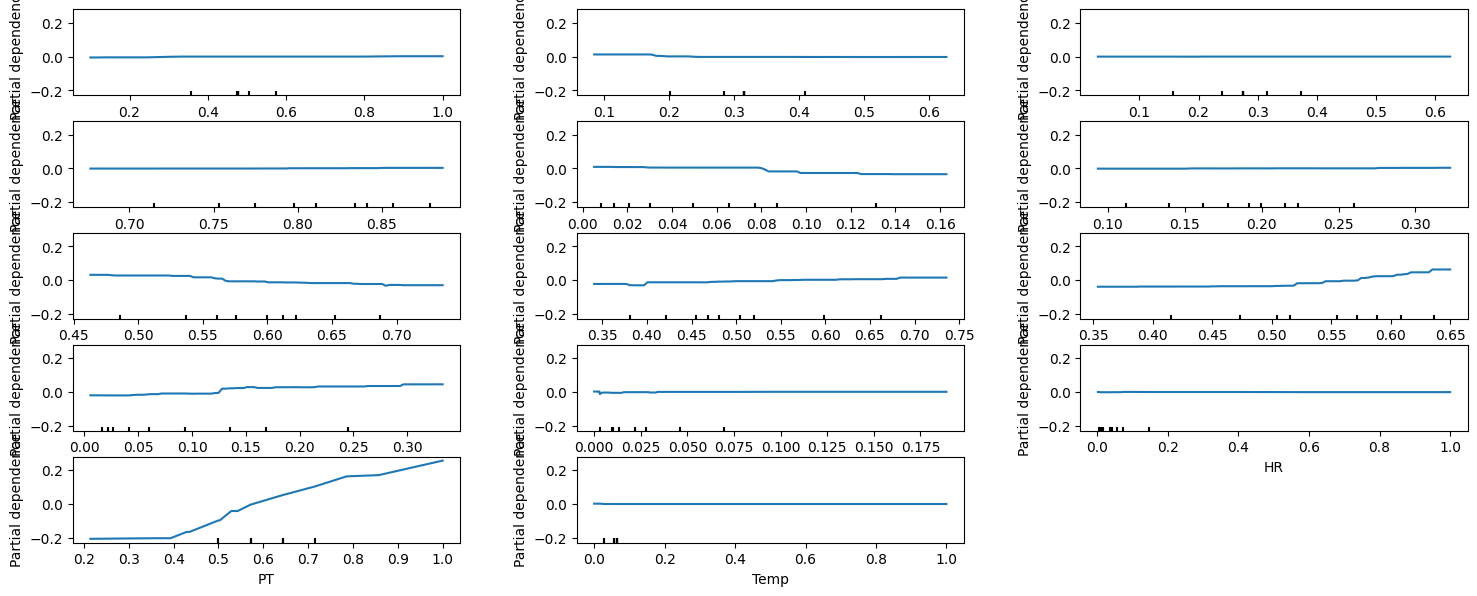

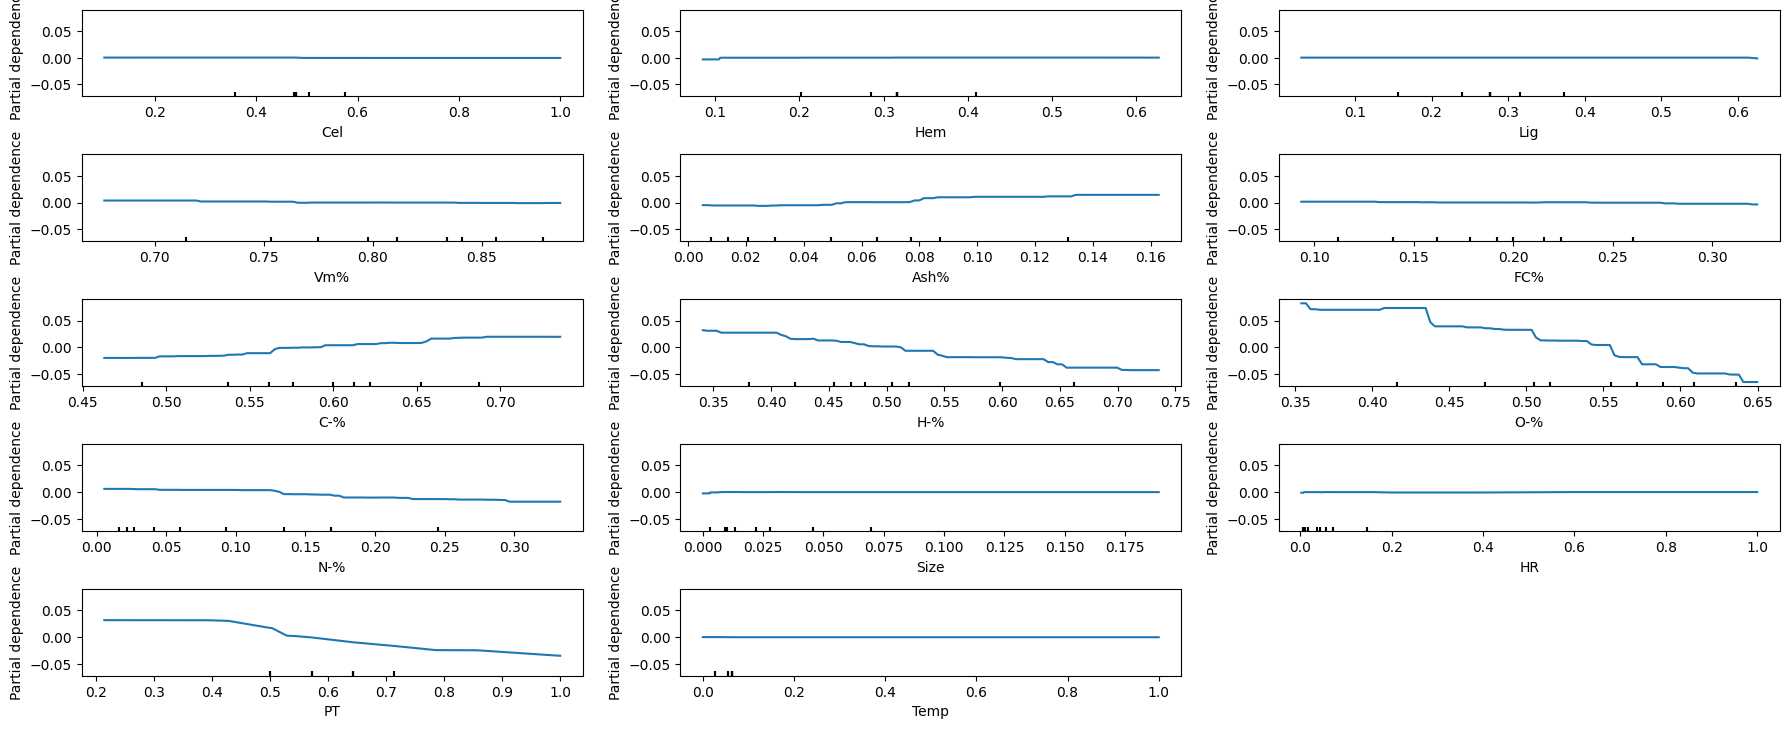

In [ ]:
performance = build_models(x_new, y_new,test_fraction = 0.15, modelname = 'GBR', random_state = 42, CV_folds = 5, optimisation = False, display = True,graph=True) 

In [ ]:
performance

,R2_train,R2_test,RMSE_train,RMSE_test,MSE_train,MSE_test,R2_CV,RMSE_CV,MAE_train,MAE_test,GBR
0,0.97,0.8,0.016451,0.043033,0.000491,0.003496,0.473569,0.060795,0.011143,0.028138,GBR


In [ ]:
## Get the performance of all model before removing outliers and optimization set to false
get_scores(X,Y,opt=False)

,R2_train,R2_test,RMSE_train,RMSE_test,MSE_train,MSE_test,R2_CV,RMSE_CV,MAE_train,MAE_test
SVM,0.63,0.50,0.075092,0.080965,0.006560,0.007740,0.457489,0.087403,0.057185,0.060612
RF,0.94,0.72,0.029827,0.059357,0.001031,0.004720,0.608256,0.073929,0.017103,0.038920
XGB,0.96,0.72,0.019864,0.059318,0.000667,0.004717,0.606801,0.069458,0.012933,0.036807
ANN,0.93,0.60,0.026867,0.064091,0.001272,0.006996,-1.255049,0.129979,0.018373,0.044656
GBR,0.97,0.75,0.017471,0.053710,0.000524,0.004135,0.626036,0.066898,0.011676,0.034933
ADA,0.83,0.68,0.051635,0.065704,0.003093,0.005141,0.580859,0.076075,0.042294,0.051669
SGD,0.10,0.06,0.124645,0.114138,0.015749,0.013247,0.063201,0.122620,0.081269,0.075126


In [ ]:
## Get the performance of all model before removing outliers and optimization set to True
get_scores(X,Y,opt=True)

2023-01-06 23:54:56,287	INFO tune.py:762 -- Total run time: 6.81 seconds (6.53 seconds for the tuning loop).


Best parameters for the model are {'estimator__alpha': 1e-07, 'estimator__epsilon': 0.001, 'estimator__loss': 'epsilon_insensitive', 'estimator__max_iter': 1000, 'estimator__tol': 1e-05}


,R2_train,R2_test,RMSE_train,RMSE_test,MSE_train,MSE_test,R2_CV,RMSE_CV,MAE_train,MAE_test
RF,0.885257,0.731470,0.042706,0.059605,0.002097,0.004680,0.616043,0.073305,0.024862,0.039181
XGB,0.944793,0.732921,0.030280,0.060337,0.000957,0.004459,0.641326,0.068371,0.019580,0.039737
ANN,0.636259,0.578114,0.069450,0.076569,0.006852,0.007612,0.528011,0.075939,0.049767,0.054337
GBR,0.954745,0.732152,0.022713,0.058031,0.000844,0.004526,0.647925,0.067870,0.004831,0.033930
ADA,0.921744,0.772229,0.031957,0.054208,0.001425,0.003857,0.653827,0.066814,0.024330,0.039233
SGD,0.561448,0.499461,0.077577,0.083528,0.008212,0.008961,0.490450,0.081896,0.046633,0.052058


In [ ]:
### works if optimization is set to true, without removing outliers
fig = px.box(best_cv_df, x='model', y='RMSLE', color='model', width=600)
fig.show()

In [ ]:
## Get the performance of all model after removing outliers and optimization set to False
get_scores(x_new,y_new,opt=False)

,R2_train,R2_test,RMSE_train,RMSE_test,MSE_train,MSE_test,R2_CV,RMSE_CV,MAE_train,MAE_test
SVM,0.57,0.53,0.067962,0.068314,0.005304,0.006021,0.347503,0.079877,0.052334,0.053791
RF,0.93,0.74,0.027376,0.051279,0.000960,0.003968,0.553753,0.065619,0.016446,0.033433
XGB,0.96,0.81,0.018650,0.042833,0.000601,0.003275,0.446790,0.062001,0.012612,0.028559
ANN,0.96,0.69,0.019941,0.052285,0.000650,0.005729,-0.168917,0.083283,0.012252,0.037630
GBR,0.97,0.80,0.016451,0.043033,0.000491,0.003496,0.473569,0.060795,0.011143,0.028138
ADA,0.81,0.65,0.046213,0.058279,0.002759,0.004773,0.316916,0.071889,0.037921,0.044712
SGD,-0.01,-0.09,0.103325,0.099738,0.011196,0.011180,-0.047082,0.101902,0.072871,0.069072


In [ ]:
## Get the performance of all model after removing outliers and optimization set to True
get_scores(x_new,y_new,opt=True)

2023-01-25 09:48:36,305	INFO tune.py:762 -- Total run time: 9.77 seconds (9.39 seconds for the tuning loop).


Best parameters for the model are {'estimator__alpha': 1e-07, 'estimator__epsilon': 0.001, 'estimator__loss': 'epsilon_insensitive', 'estimator__max_iter': 1000, 'estimator__tol': 1e-05}


,R2_train,R2_test,RMSE_train,RMSE_test,MSE_train,MSE_test,R2_CV,RMSE_CV,MAE_train,MAE_test
RF,0.86,0.73,0.038830,0.053492,0.001823,0.004203,0.576725,0.065170,0.023418,0.036959
XGB,0.92,0.75,0.029218,0.050393,0.000903,0.003825,0.641665,0.059606,0.018648,0.033785
ANN,0.58,0.59,0.065310,0.068149,0.006217,0.007124,0.476097,0.069549,0.045570,0.046024
GBR,0.93,0.79,0.022023,0.046528,0.000942,0.003632,0.655604,0.058447,0.004499,0.027909
ADA,0.90,0.74,0.030058,0.051647,0.001511,0.004353,0.597521,0.061839,0.022378,0.037318
SGD,0.50,0.48,0.071228,0.077491,0.007247,0.009273,0.489911,0.071246,0.043192,0.045333


In [ ]:
### works if optimization is set to true and outliers removed
fig = px.box(best_cv_df, x='model', y='RMSLE', color='model', width=600)
fig.show()

## Feature Selection

In [ ]:
#### After feature selection 
cols_str = ['Cel', 'Hem', 'Lig', 'Vm%', 'Ash%', 'FC%', 'C-%', 'H-%', 'O-%', 'N-%','Size', 'HR', 'PT', 'Temp']
#cols = [2,3,7,8,9,11,12,13]
cols = [2,4,8,7,9,10,12]
x_cols = ['Lig','Ash%','O-%','H-%','N-%','Size','PT']
X = X[:,cols]

In [ ]:
## Get the performance of all model before removing outliers and optimization set to false
get_scores(X,Y,opt=False)

In [ ]:
## Get the performance of all model before removing outliers and optimization set to True
get_scores(X,Y,opt=True)

In [ ]:
### works if optimization is set to true, without removing outliers
fig = px.box(best_cv_df, x='model', y='RMSLE', color='model', width=600)
fig.show()

In [ ]:
## Get the performance of all model after removing outliers and optimization set to False
get_scores(x_new[:,cols],y_new,opt=False)

In [ ]:
performance = build_models(x_new[:,cols], y_new,test_fraction = 0.15, modelname = 'GBR', random_state = 42, CV_folds = 5, optimisation = False, display = True,graph=True,x_cols = x_cols) 

In [ ]:
## Get the performance of all model after removing outliers and optimization set to True
get_scores(x_new[:,cols],y_new,opt=True)

In [ ]:
### works if optimization is set to true, without removing outliers
fig = px.box(best_cv_df, x='model', y='RMSLE', color='model', width=600)
fig.show()

In [ ]:
# converts the data to its original scale
x_new,y_new = post_scale_data(mm_X,mm_Y,x_new,y_new)

In [ ]:
# important columns
cols = [2,4,8,7,9,10,12]
#important features
x_cols=['Lig','Ash%','O-%','H-%','N-%','Size','PT']

GBR model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



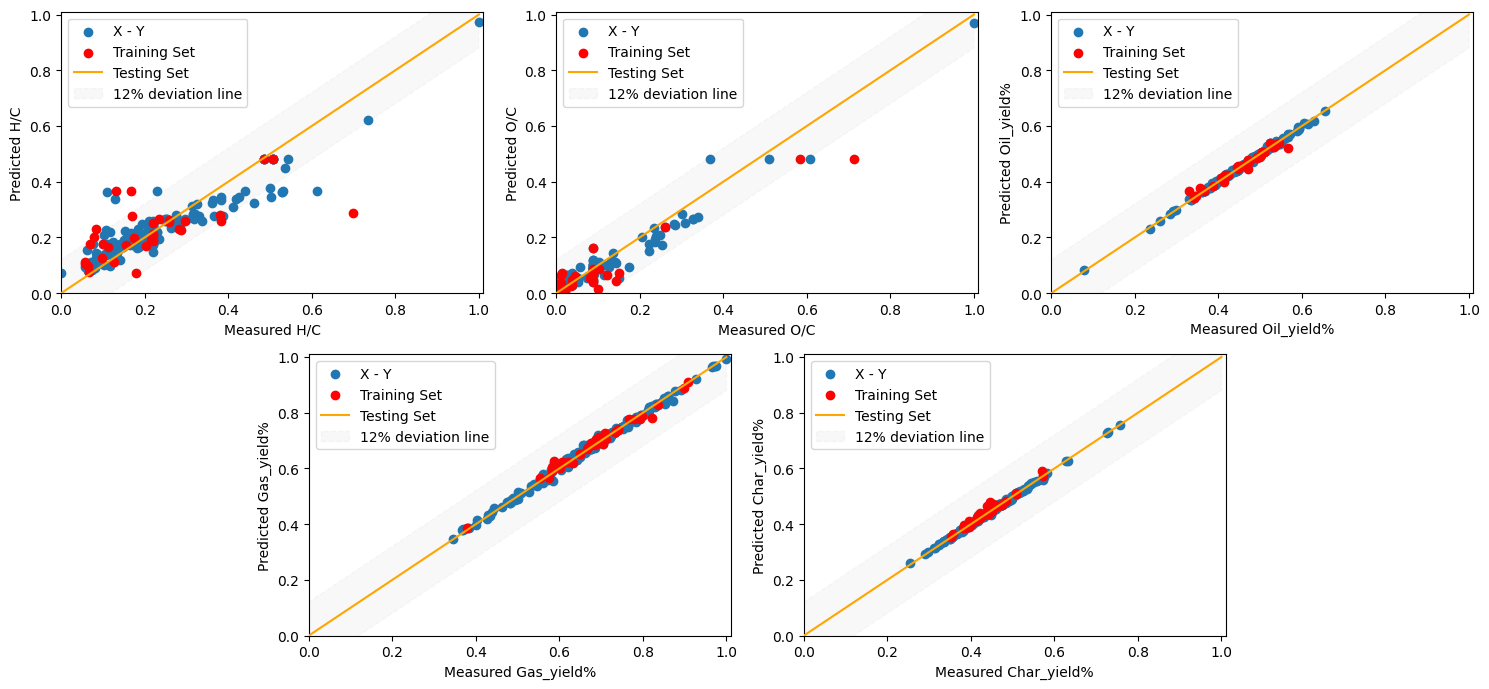

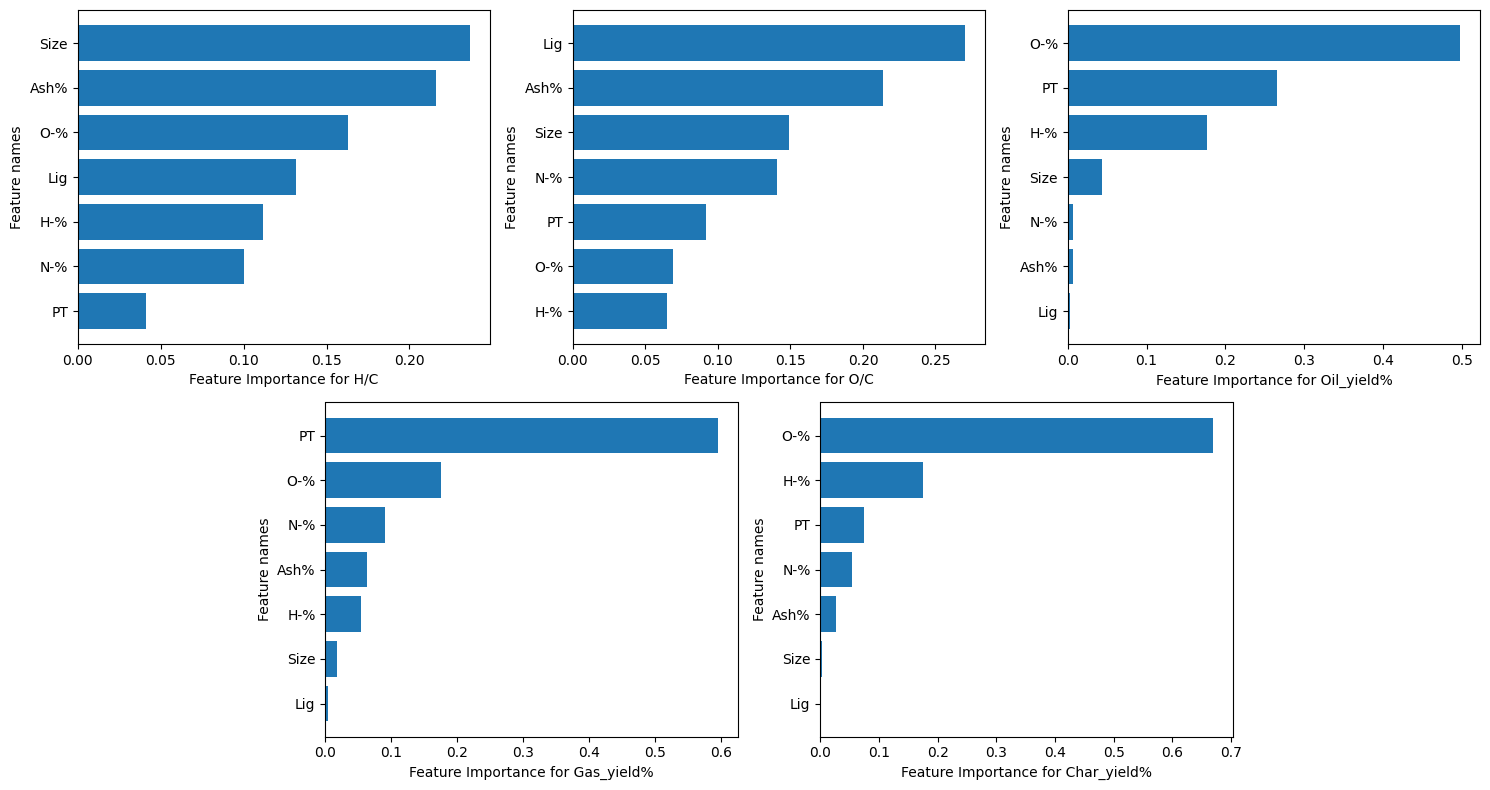

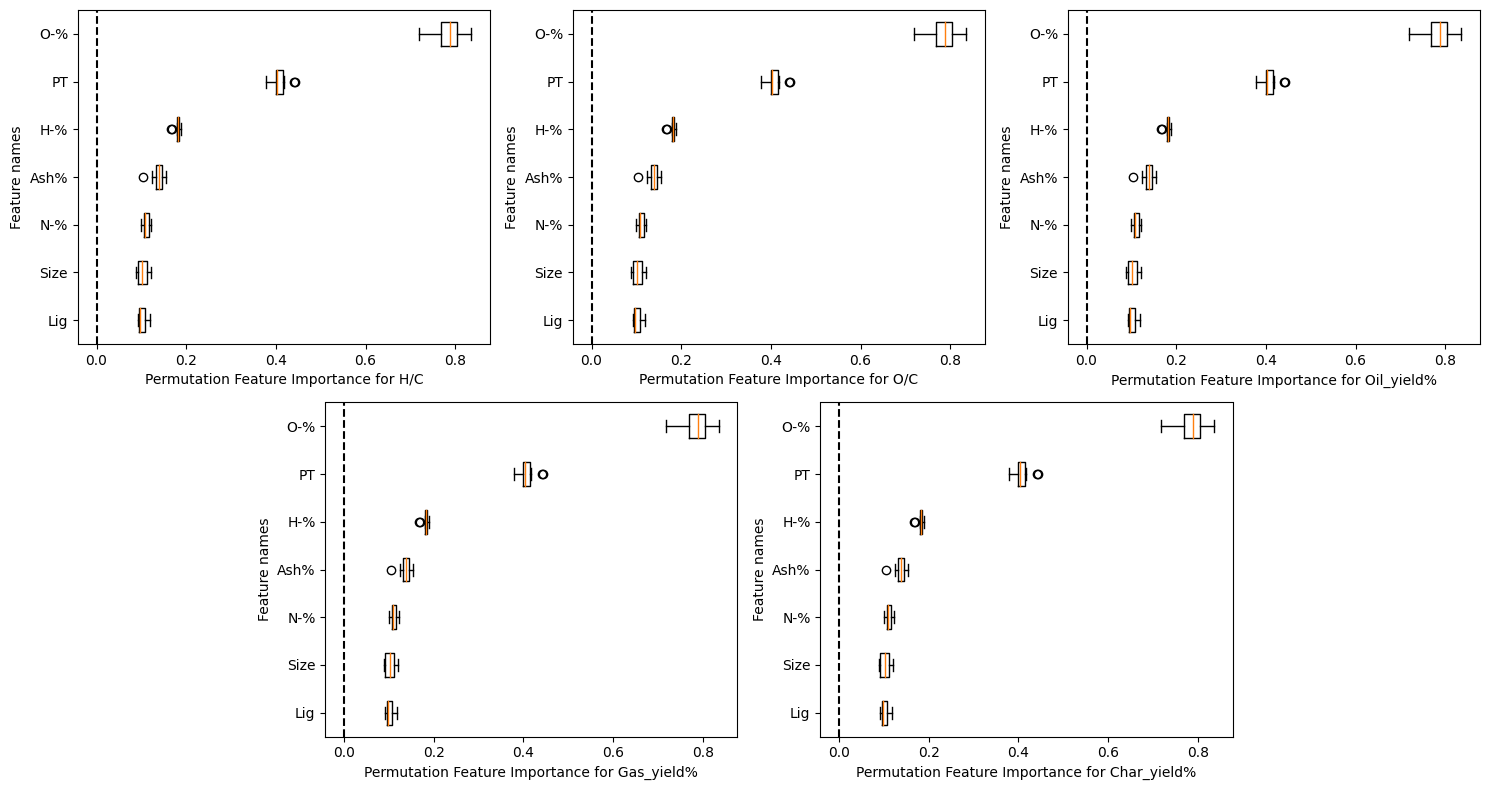

  0%|          | 0/37 [00:00<?, ?it/s]

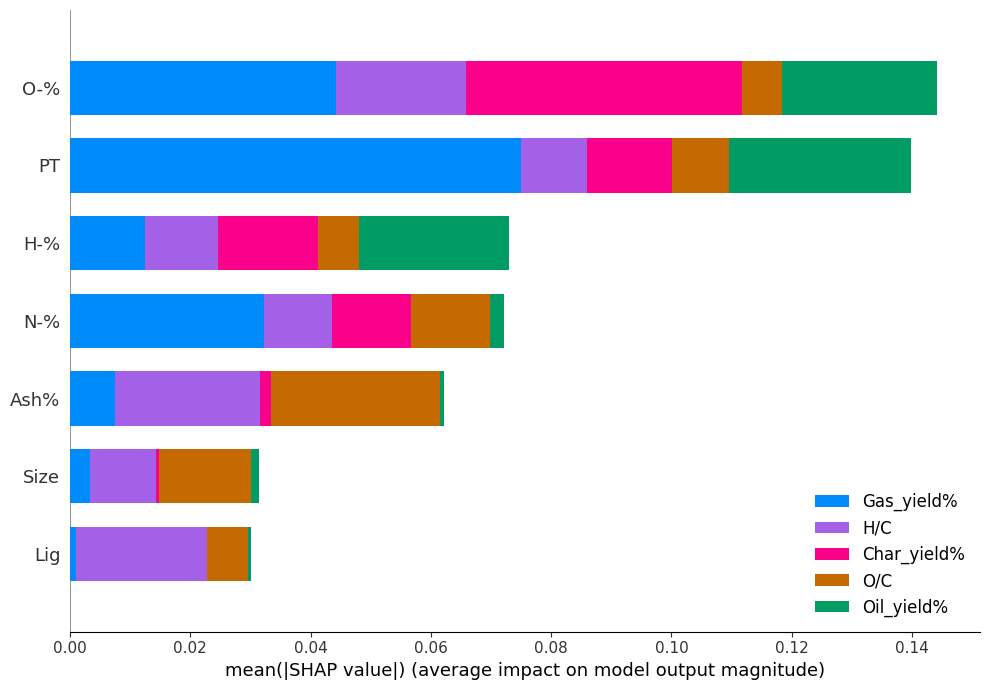

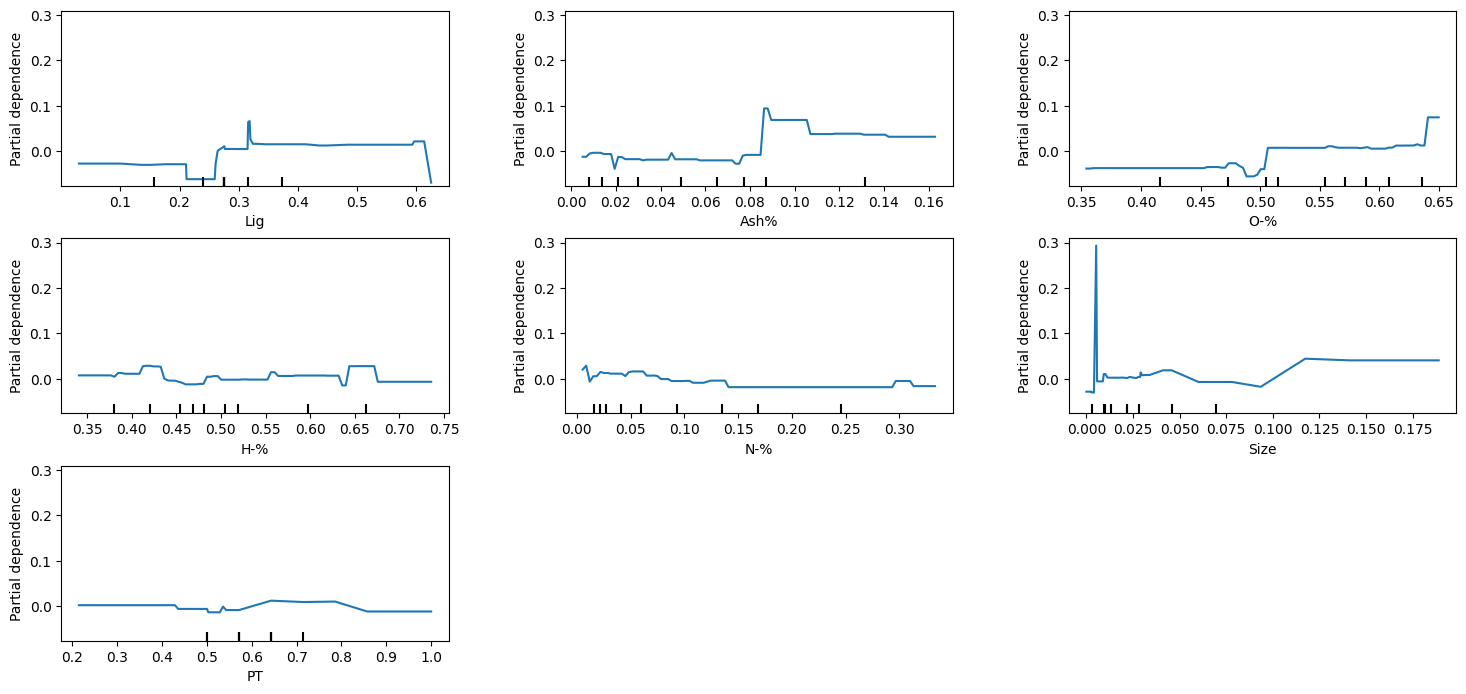

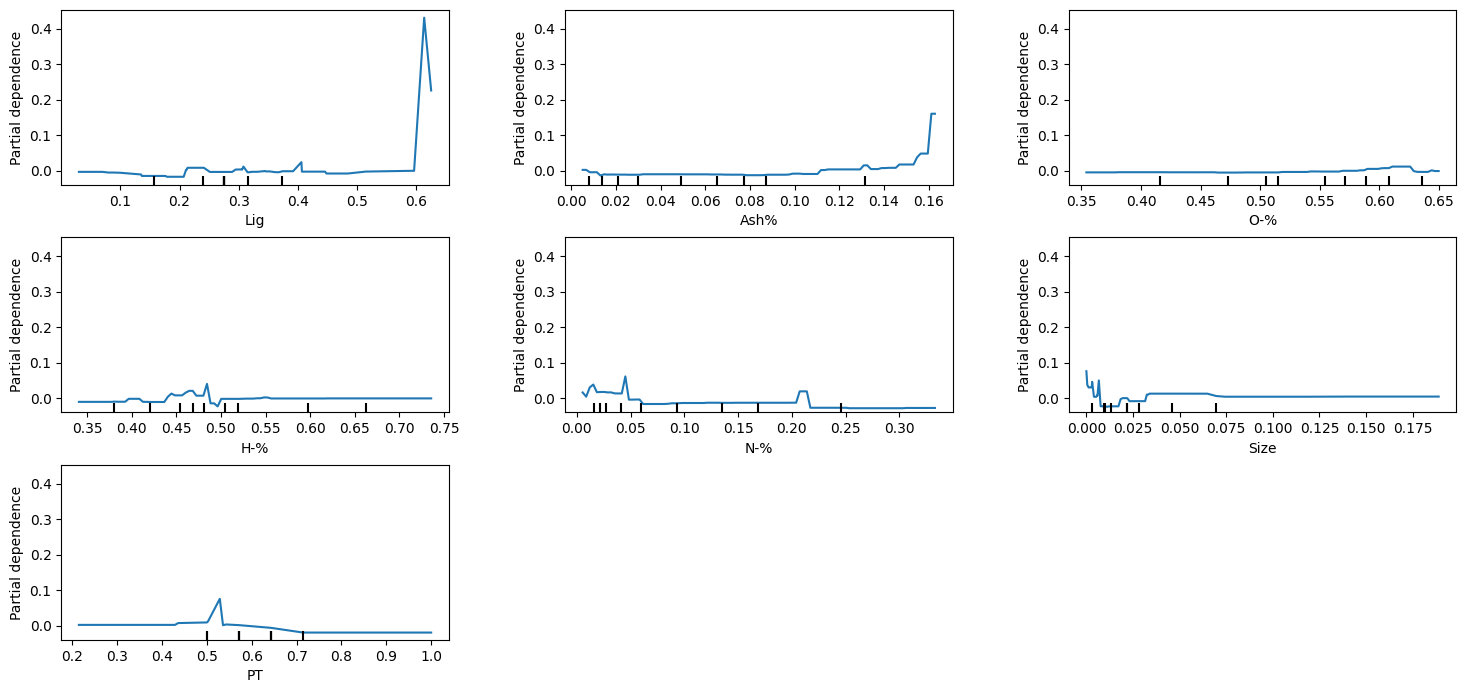

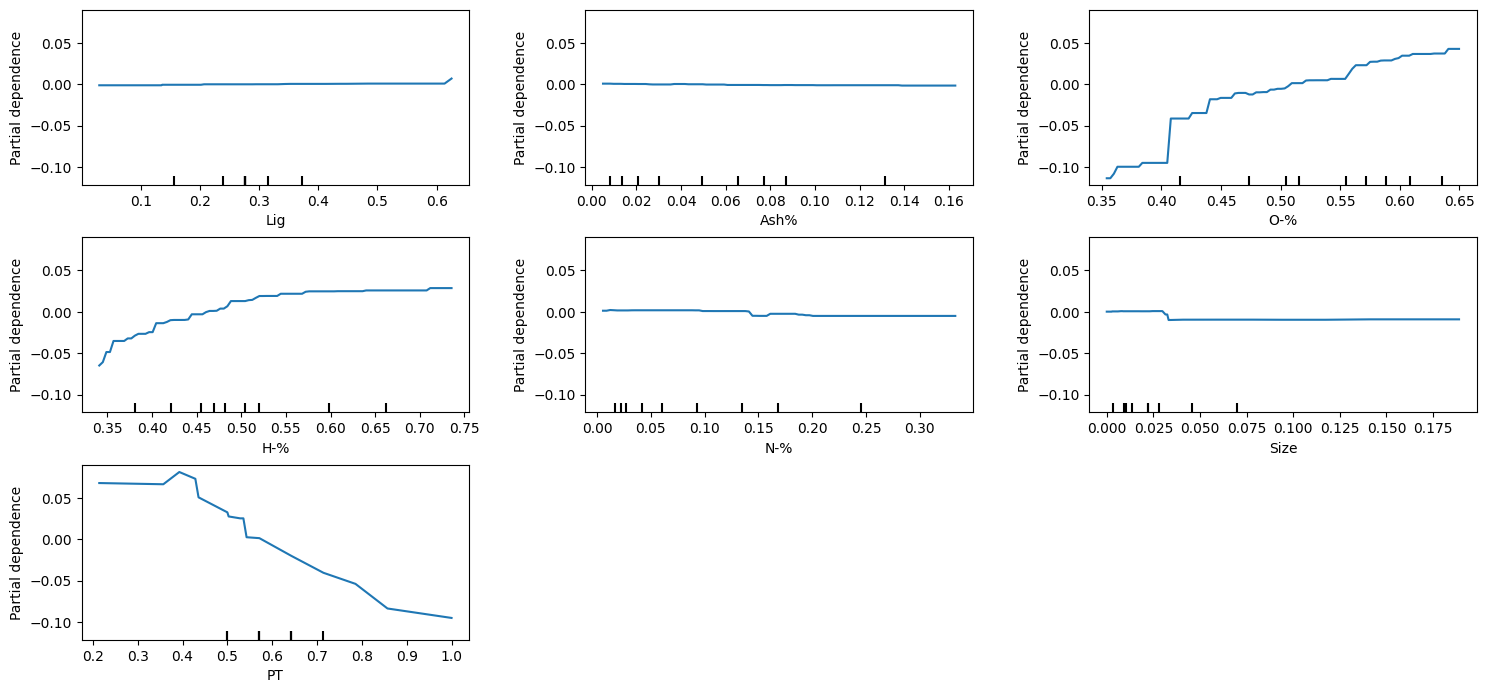

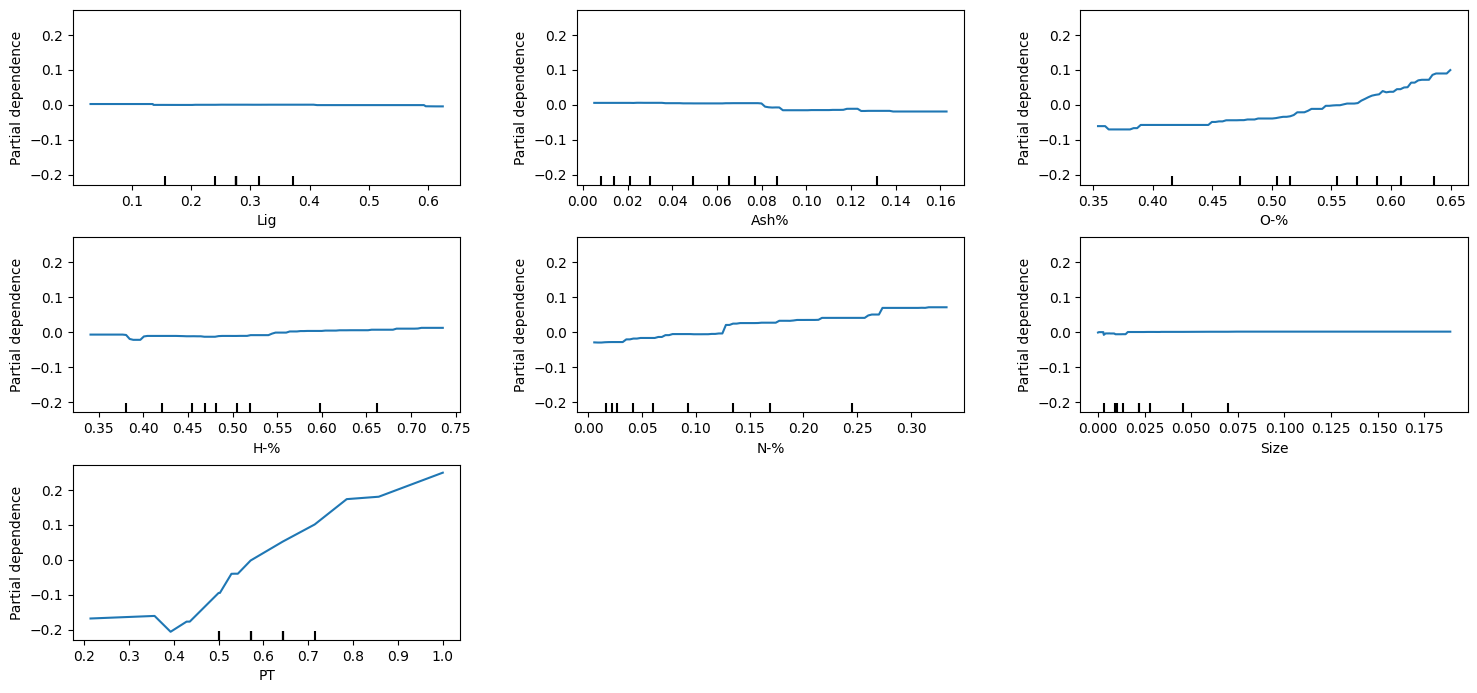

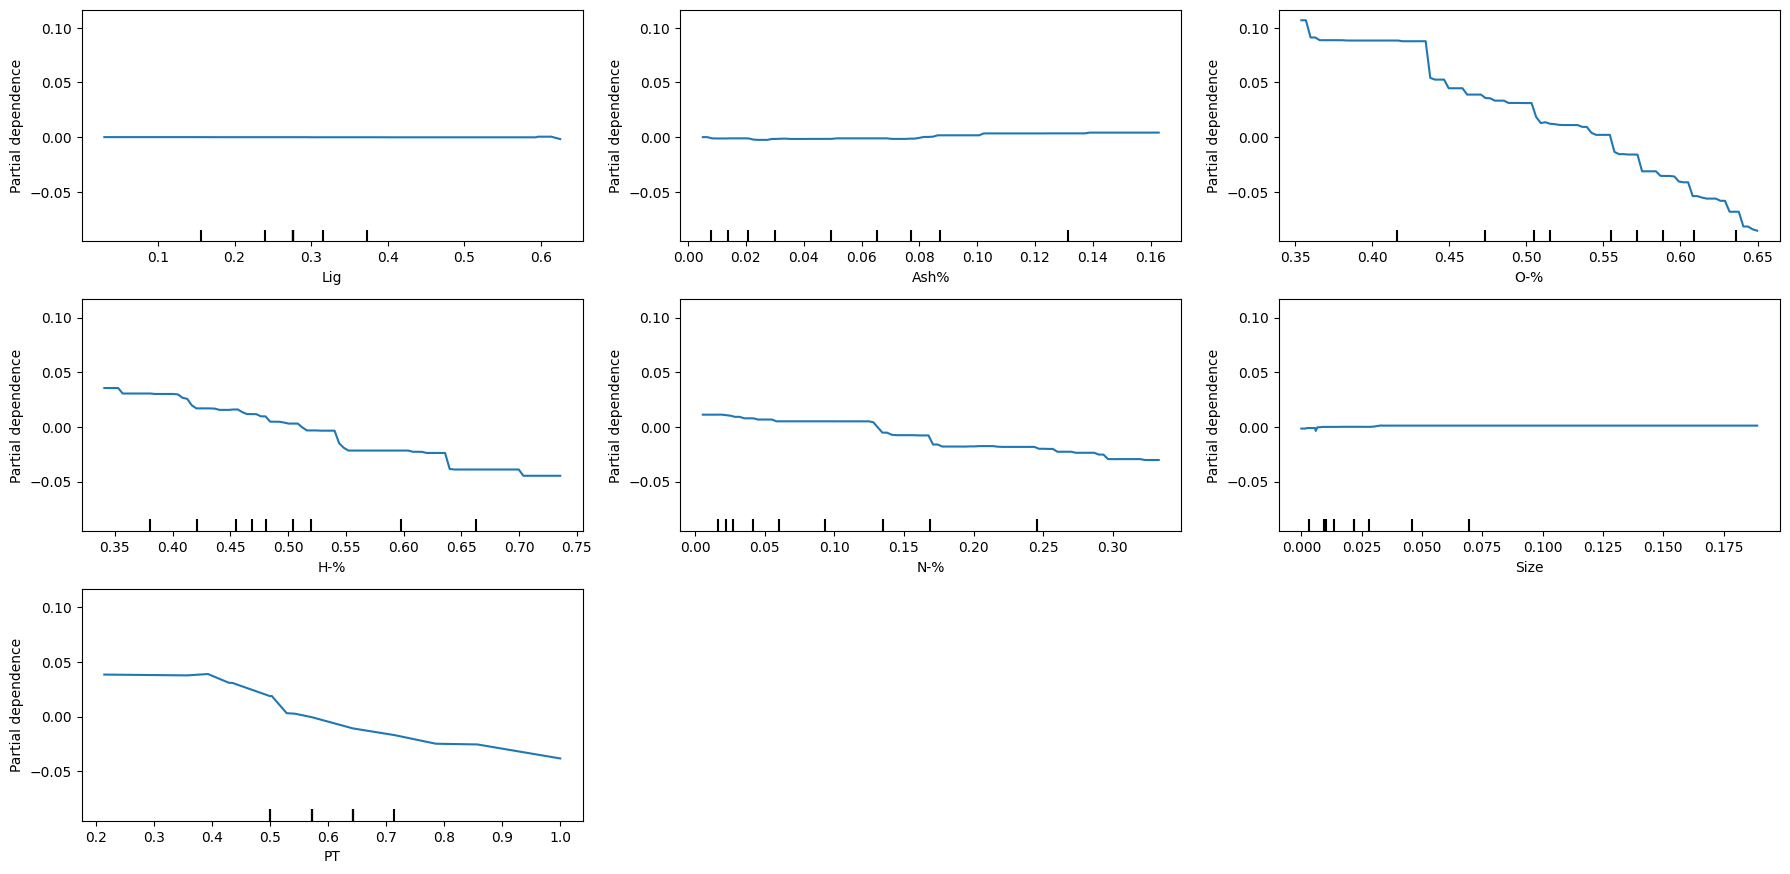

In [ ]:
performance = build_models(x_new[:,[2,4,8,7,9,10,12]], y_new,test_fraction = 0.15, modelname = 'GBR', random_state = 42, CV_folds = 5, optimisation = False, display = True,graph=True,x_cols=['Lig','Ash%','O-%','H-%','N-%','Size','PT']) 